In [21]:
import sys
sys.path.append('ML4QS-master')
%matplotlib inline

import copy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
from util import util
from util.VisualizeDataset import VisualizeDataset
data1 = pd.read_csv('./datasets/bike.csv',sep=";")
data1.head()
DataViz = VisualizeDataset()

# Settings for matplotlib to ensure readable plots
plt.rcParams["figure.figsize"] = [20,15]
matplotlib.rc('font', **{'family' : 'normal', 'size'   : 22})
matplotlib.rc('xtick',labelsize=22)
matplotlib.rc('ytick',labelsize=22)



# ignore DeprecationWarnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Chapter 2: Basics of Sensory Data

In [36]:
data1 = data1.iloc[:,:16]
data1 = data1.dropna()
data1.shape
#data1.info()
#type object instead of float64..
#data1 = data1.astype('float64', raise_on_error = True) #doesnot work
#data1 = pd.to_numeric(data1, errors= 'coerce') #doesnt work
data1 = data1.convert_objects(convert_numeric=True) #Type 'Number' in Excel becomes NaN,  type 'General' gets float
#might wanna focus on the 2 sources that are complete: rotation/gravity
rotation_data = data1.iloc[:,4:7] #has NaN
rotation_data.head()
gravity_data = data1.iloc[:,7:10] #no NaN
user_acc_data = data1.iloc[:,10:13] #has NaN
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34748 entries, 0 to 34747
Data columns (total 1 columns):
timestamp(unix),attitude_roll(radians),attitude_pitch(radians),attitude_yaw(radians),rotation_rate_x(radians/s),rotation_rate_y(radians/s),rotation_rate_z(radians/s),gravity_x(G),gravity_y(G),gravity_z(G),user_acc_x(G),user_acc_y(G),user_acc_z(G),magnetic_field_x(microteslas),magnetic_field_y(microteslas),magnetic_field_z(microteslas),latitude(degree),longitude(degree),altitude(meter),speed(m/s),course(degree),timestamp(unix),User Mark    34748 non-null object
dtypes: object(1)
memory usage: 542.9+ KB


/Users/davidstap/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [38]:
rotation_data.describe()
#plt.hist(rotation_data['rotation_rate_x(radians/s)'].dropna())
#plt.hist(rotation_data['rotation_rate_y(radians/s)'].dropna())
#plt.hist(rotation_data['rotation_rate_z(radians/s)'].dropna())
#plt.show()
DataViz.plot_dataset_boxplot(rotation_data, ['rotation_rate_x(radians/s)','rotation_rate_y(radians/s)','rotation_rate_z(radians/s)'])

In [ ]:
gravity_data.describe()
#plt.hist(gravity_data['gravity_x(G)'])
#plt.hist(gravity_data['gravity_y(G)'])
#plt.hist(gravity_data['gravity_z(G)'])
#plt.show()
DataViz.plot_dataset_boxplot(gravity_data, ['gravity_x(radians/s)','gravity_rate_y(radians/s)','gravity_rate_z(radians/s)'])

In [ ]:
user_acc_data.describe()
#plt.hist(user_acc_data['user_acc_x(G)'].dropna())
#plt.hist(user_acc_data['user_acc_y(G)'].dropna())
#plt.hist(user_acc_data['user_acc_z(G)'].dropna())
#plt.show()
DataViz.plot_dataset_boxplot(user_acc_data, ['user_acc_x(radians/s)','user_acc_y(radians/s)','user_acc_z(radians/s)'])

In [ ]:
label_data = pd.DataFrame()
label_data['Sensor_type'] = ['interval_label']
label_data['Device_type'] = ['smartphone']
label_data['Label'] = ['Cycling']
label_data['Label_start'] = [data1['timestamp(unix)'].min()]
label_data['Label_end'] = [data1['timestamp(unix)'].max()]
label_data.head(5)

In [ ]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 2                                               #
#                                                            #
##############################################################

import pandas as pd
import numpy as np
import re
import copy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as md


class CreateDataset():

    base_dir = ''
    granulairity = 0
    data_table = None

    def __init__(self, base_dir, granularity):
        self.base_dir = base_dir
        self.granularity = granularity

    # Create an initial data table with entries from start till end time, with steps
    # of size granularity. Granularity is specified in milliseconds
    def create_timestamps(self, start_time, end_time):
        return pd.date_range(start_time, end_time, freq=str(self.granularity)+'ms')

    def create_dataset(self, start_time, end_time, cols, prefix):
        c = copy.deepcopy(cols)
        if not prefix == '':
            for i in range(0, len(c)):
                c[i] = str(prefix) + str(c[i])
        timestamps = self.create_timestamps(start_time, end_time)
        self.data_table = pd.DataFrame(index=timestamps, columns=c)

    # Add numerical data, we assume timestamps in the form of nanoseconds from the epoch
    def add_numerical_dataset(self, file, timestamp_col, value_cols, aggregation='avg', prefix=''):
        dataset = pd.read_csv(self.base_dir + file, skipinitialspace=True)

        # Convert timestamps to dates
        dataset[timestamp_col] = pd.to_datetime(dataset[timestamp_col])

        # Create a table based on the times found in the dataset
        if self.data_table is None:
            self.create_dataset(min(dataset[timestamp_col]), max(dataset[timestamp_col]), value_cols, prefix)
        else:
            for col in value_cols:
                self.data_table[str(prefix) + str(col)] = np.nan

        # Over all rows in the new table
        for i in range(0, len(self.data_table.index)):
            # Select the relevant measurements.
            relevant_rows = dataset[
                (dataset[timestamp_col] >= self.data_table.index[i]) &
                (dataset[timestamp_col] < (self.data_table.index[i] +
                                           timedelta(milliseconds=self.granularity)))
            ]
            for col in value_cols:
                # Take the average value
                if len(relevant_rows) > 0:
                    if aggregation == 'avg':
                        self.data_table.loc[self.data_table.index[i], str(prefix)+str(col)] = np.average(relevant_rows[col])
                    else:
                        raise ValueError("Unknown aggregation '" + aggregation + "'")
                else:
                    self.data_table.loc[self.data_table.index[i], str(prefix)+str(col)] = np.nan

    # Remove undesired value from the names.
    def clean_name(self, name):
        return re.sub('[^0-9a-zA-Z]+', '', name)

    # Add data in which we have rows that indicate the occurrence of a certain event with a given start and end time.
    # 'aggregation' can be 'sum' or 'binary'.
    def add_event_dataset(self, file, start_timestamp_col, end_timestamp_col, value_col, aggregation='sum'):
        dataset = pd.read_csv(self.base_dir + file)

        # Convert timestamps to datetime.
        dataset[start_timestamp_col] = pd.to_datetime(dataset[start_timestamp_col])
        dataset[end_timestamp_col] = pd.to_datetime(dataset[end_timestamp_col])

        # Clean the event values in the dataset
        dataset[value_col] = dataset[value_col].apply(self.clean_name)
        event_values = dataset[value_col].unique()

        # Add columns for all possible values (or create a new dataset if empty), set the default to 0 occurrences
        if self.data_table is None:
            self.create_dataset(min(dataset[start_timestamp_col]), max(dataset[end_timestamp_col]), event_values, value_col)
        for col in event_values:
            self.data_table[(str(value_col) + str(col))] = 0

        # Now we need to start counting by passing along the rows....
        for i in range(0, len(dataset.index)):
            # identify the time points of the row in our dataset and the value
            start = dataset[start_timestamp_col][i]
            end = dataset[end_timestamp_col][i]
            value = dataset[value_col][i]
            border = (start - timedelta(milliseconds=self.granularity))

            # get the right rows from our data table
            relevant_rows = self.data_table[(start <= (self.data_table.index +timedelta(milliseconds=self.granularity))) & (end > self.data_table.index)]

            # and add 1 to the rows if we take the sum
            if aggregation == 'sum':
                self.data_table.loc[relevant_rows.index, str(value_col) + str(value)] += 1
            # or set to 1 if we just want to know it happened
            elif aggregation == 'binary':
                self.data_table.loc[relevant_rows.index, str(value_col) + str(value)] = 1
            else:
                raise ValueError("Unknown aggregation '" + aggregation + "'")

    # This function returns the column names that have one of the strings expressed by 'ids' in the column name.
    def get_relevant_columns(self, ids):
        relevant_dataset_cols = []
        cols = list(self.data_table.columns)

        for id in ids:
            relevant_dataset_cols.extend([col for col in cols if id in col])

        return relevant_dataset_cols



# Chapter 3: Handling Noise and Missing Values in Sensory Data

## Practical Assignment Q3.6.2.3
Use a model-based approach to impute the heart rate

In [23]:
# Load data
data = pd.read_csv('./ML4QS-master/intermediate_datafiles/chapter2_result.csv', index_col=0)
data.index = data.index.to_datetime()

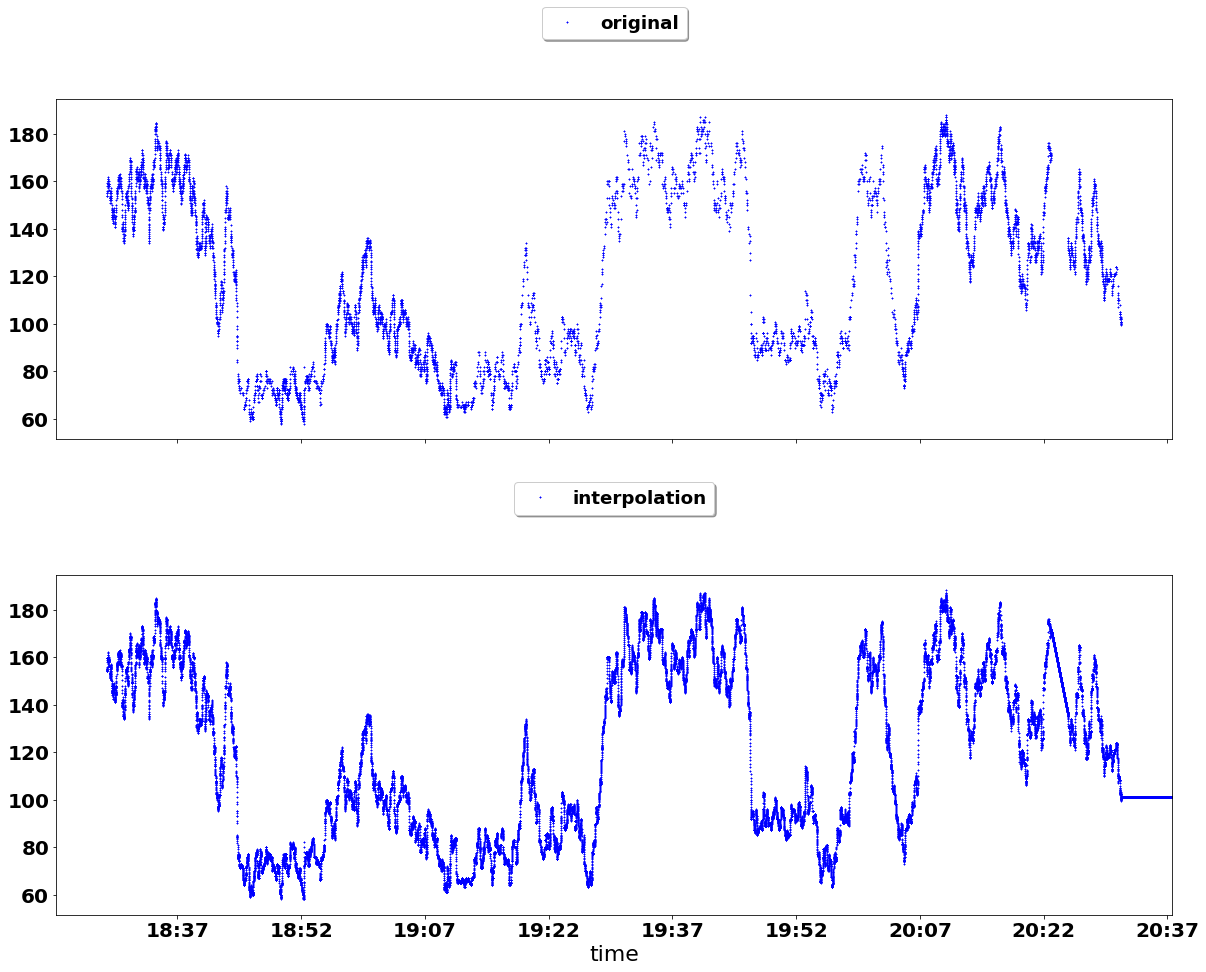

In [23]:
from Chapter3.ImputationMissingValues import ImputationMissingValues
from util.VisualizeDataset import VisualizeDataset

# Choose attribute
col = 'hr_watch_rate'

# Create imputation and visualization instance
MisVal = ImputationMissingValues()
DataViz = VisualizeDataset()

# Use interpolation function. Result: heart rate data imputed
data_imputed_interpolation = MisVal.impute_interpolate(copy.deepcopy(data),col)

# Visualize result
DataViz.plot_imputed_values(data, ['original', 'interpolation'], 'hr_watch_rate', data_imputed_interpolation['hr_watch_rate'])

## Practical Assignment Q3.6.2.2
To generate Figs. 3.8 and 3.9 we have used the parameter settings described in Sect.3.5.1. Vary the constant c (smaller and larger values) of the Chauvenet’s criterion and study the dependency of the number of detected outliers on c. Repeat this for the other three methods presented for outlier detection. Use the source code from book’s website, that generated the figures, as a starting point for the analysis.

### Distribution-based: Chauvenet's criterion

In [25]:
from Chapter3.OutlierDetection import DistributionBasedOutlierDetection

col = 'light_phone_lux'
OutlierDistr = DistributionBasedOutlierDetection()

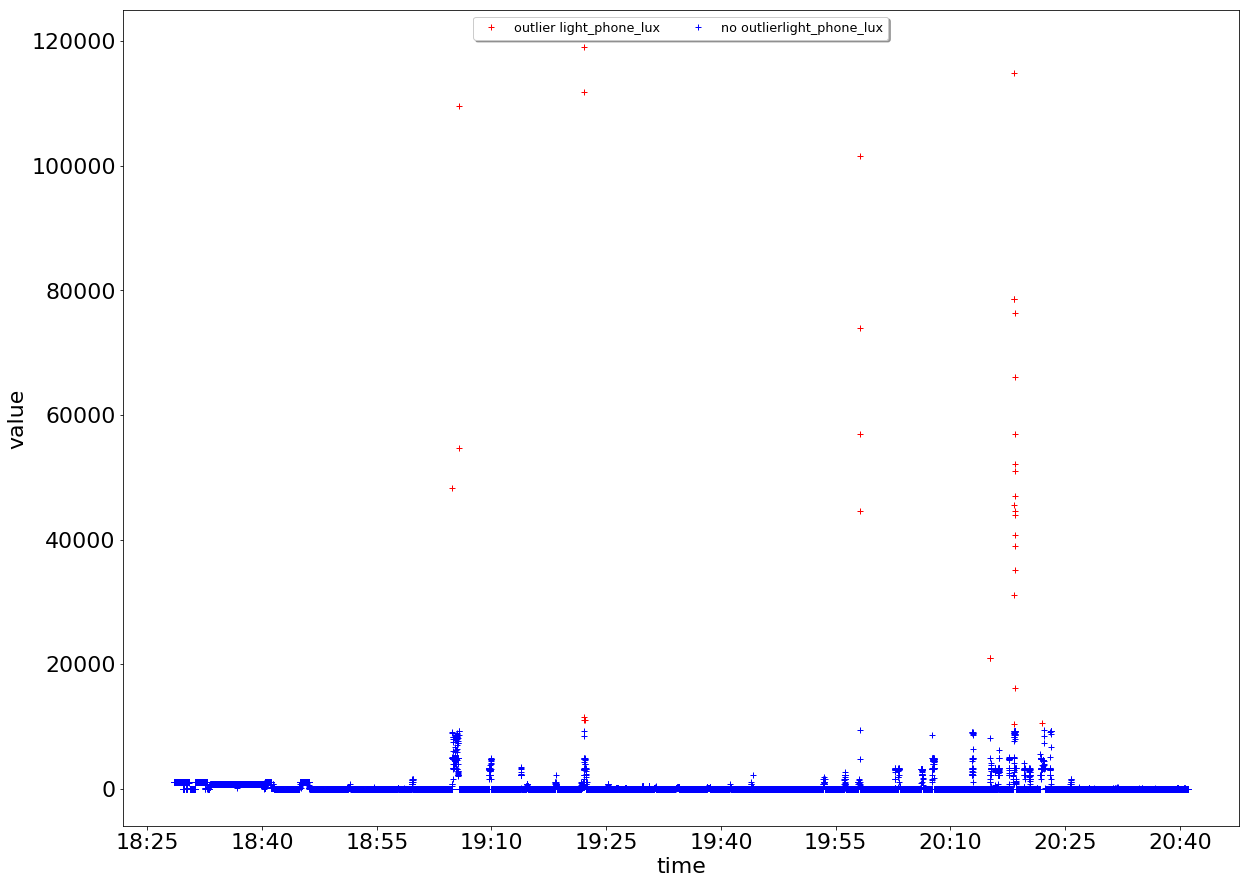

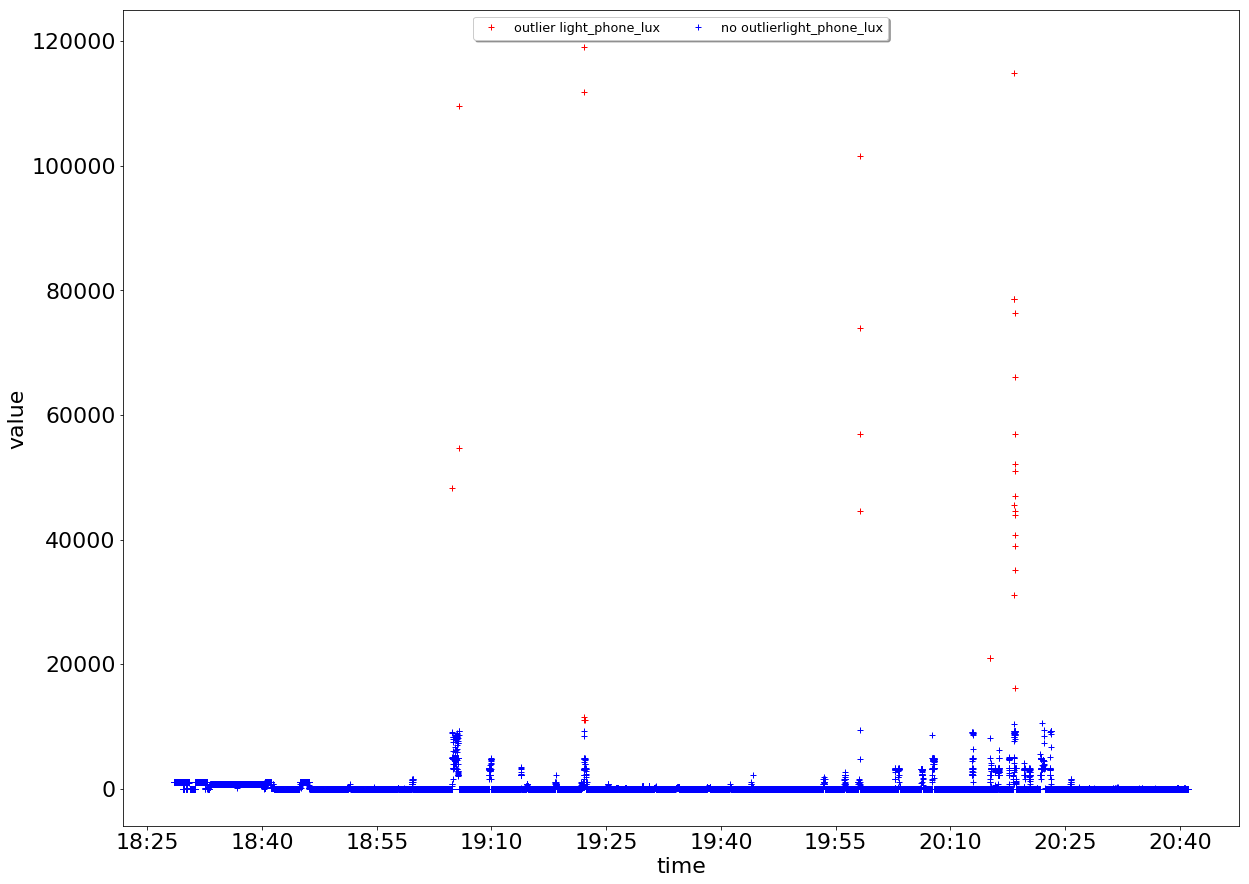

In [29]:
for c in [2,10]:
    dataset_outliers_chauvenet = OutlierDistr.chauvenet(copy.deepcopy(data), col, c)
    DataViz.plot_binary_outliers(dataset_outliers_chauvenet, col, col + '_outlier')

# higher c corresponds to higher chance that outliers are truly outliers

### Distribution-based: Mixture models

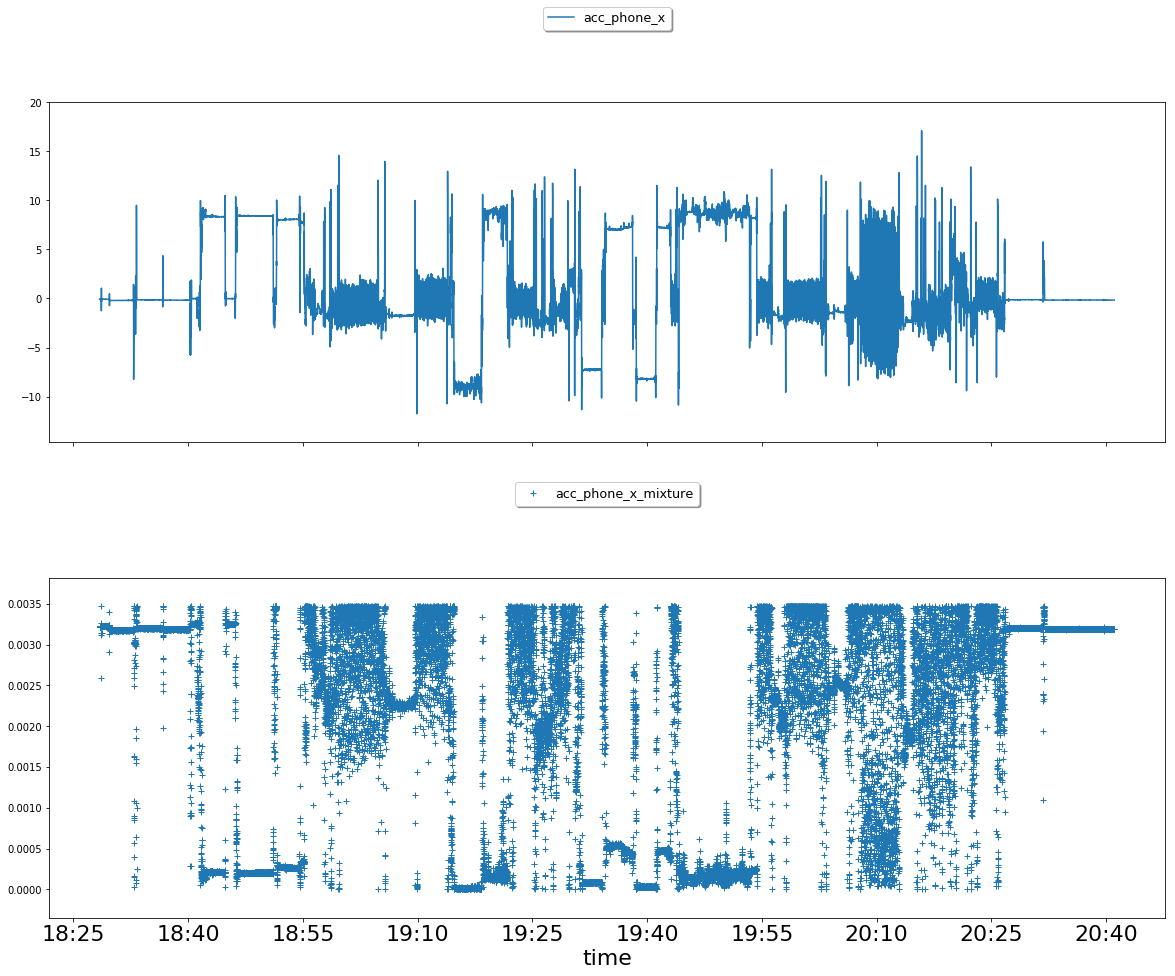

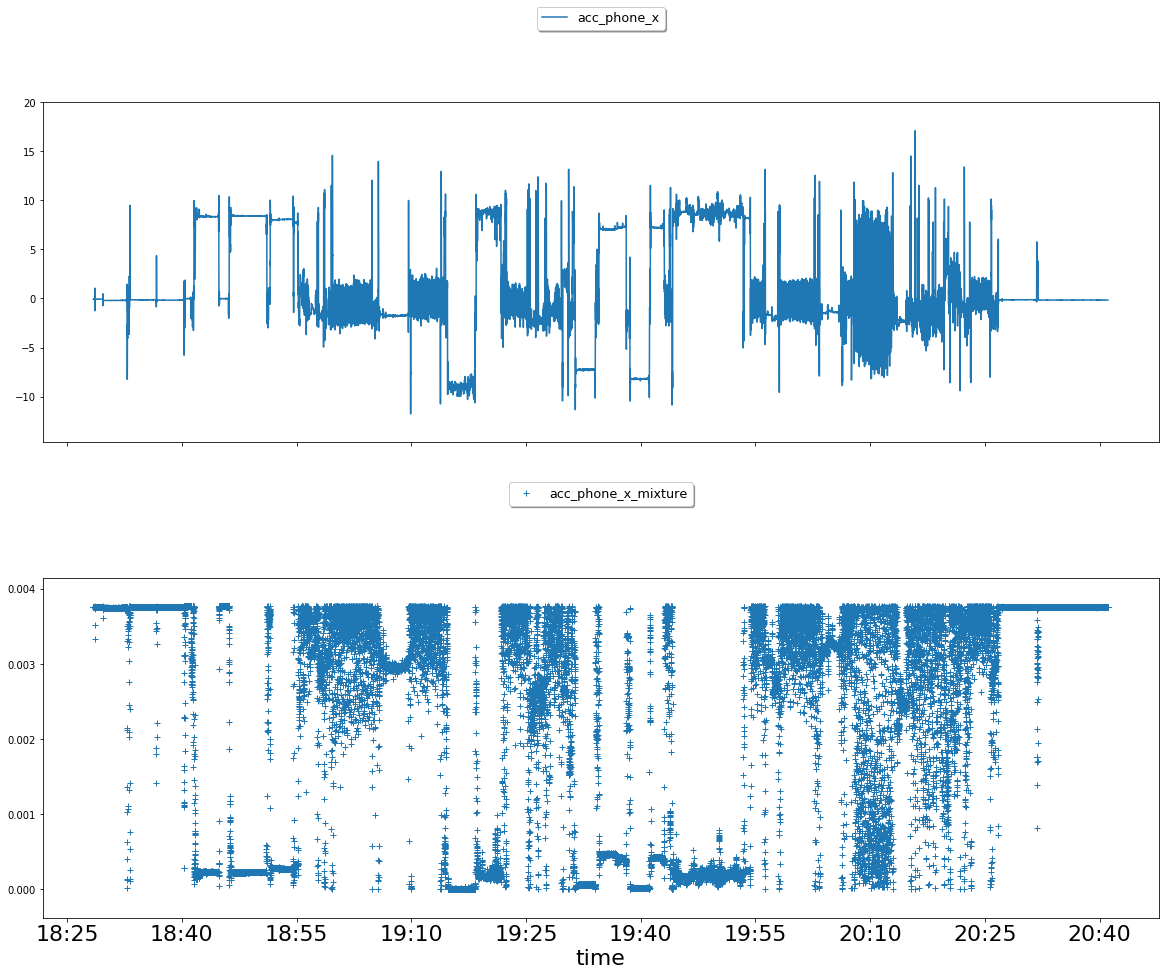

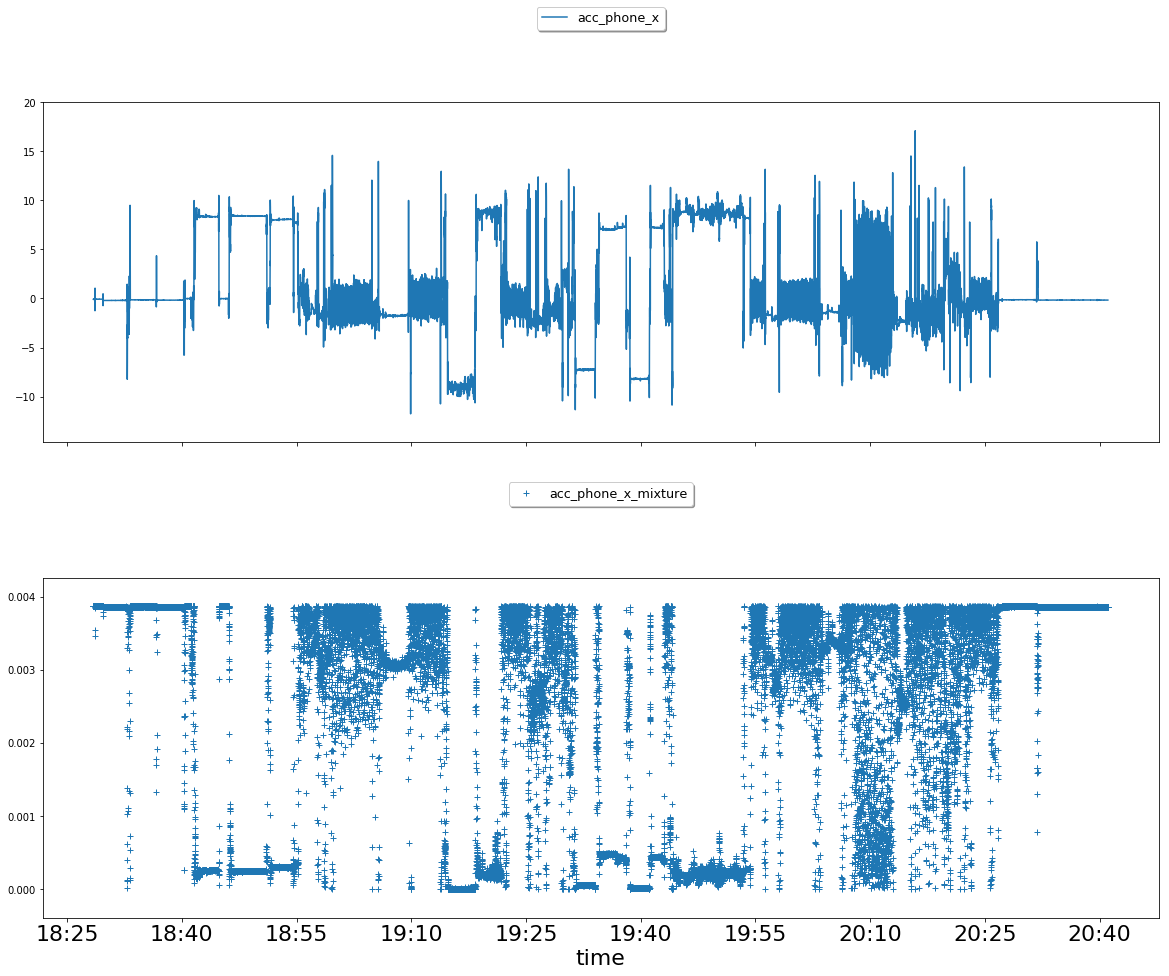

In [11]:
for k in [1,10,100]:
    dataset_outliers_mixture = OutlierDistr.mixture_model(copy.deepcopy(data), col, k)
    DataViz.plot_dataset(dataset_outliers_mixture, [col, col + '_mixture'], ['exact','exact'], ['line', 'points'])

    # higher values of k result in higher probabilities of observing a datapoint (as expected, since this allows for
    # a better fit to the dataset). The resulting dataset however hardly differs. Choosing low value is in this case fine,
    # this saves some computation.

### Distance-based: Simple distance-based approach

In [3]:
from Chapter3.OutlierDetection import DistanceBasedOutlierDetection

OutlierDist = DistanceBasedOutlierDetection()

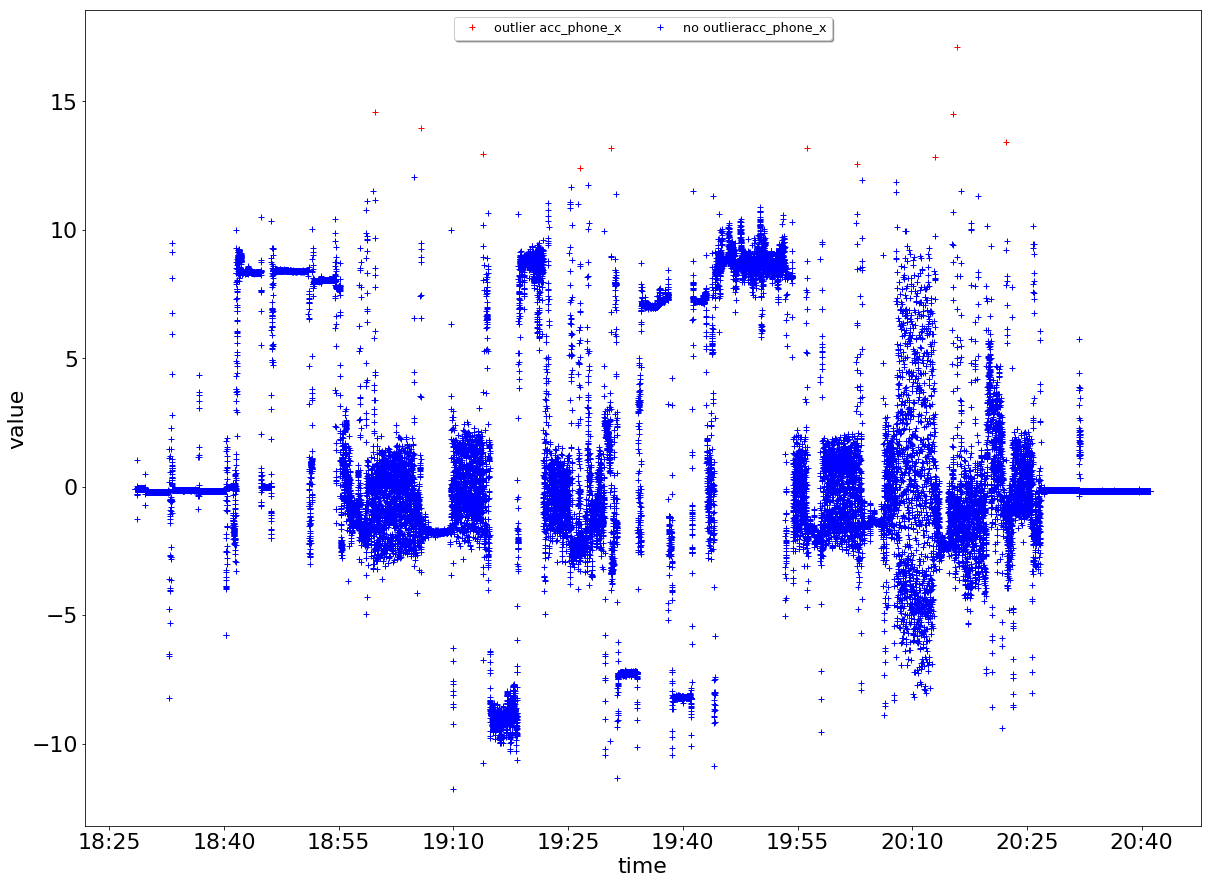

In [8]:
# Values used in book

dataset_outliers_sdb = OutlierDist.simple_distance_based(copy.deepcopy(data), [col], 'euclidean', 0.10, 0.99)
DataViz.plot_binary_outliers(dataset_outliers_sdb, col, 'simple_dist_outlier')

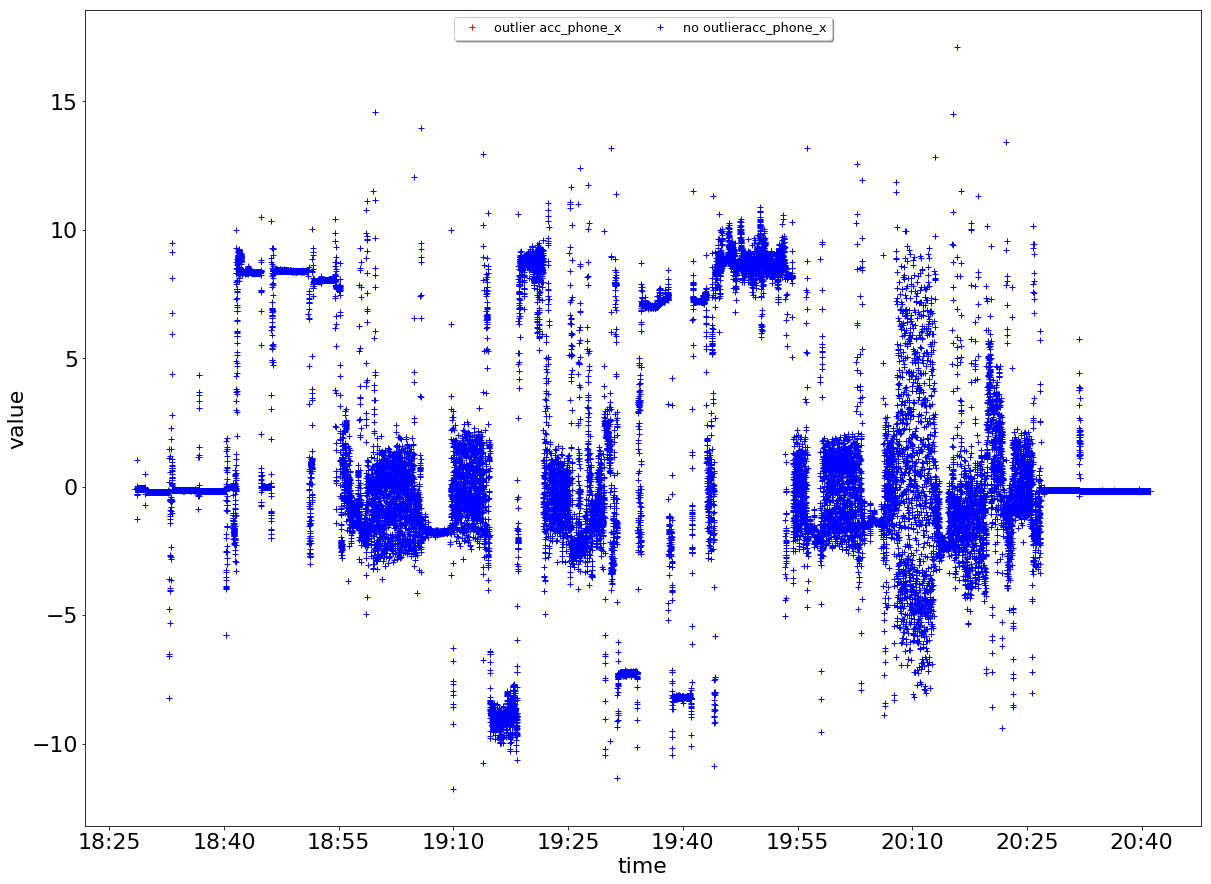

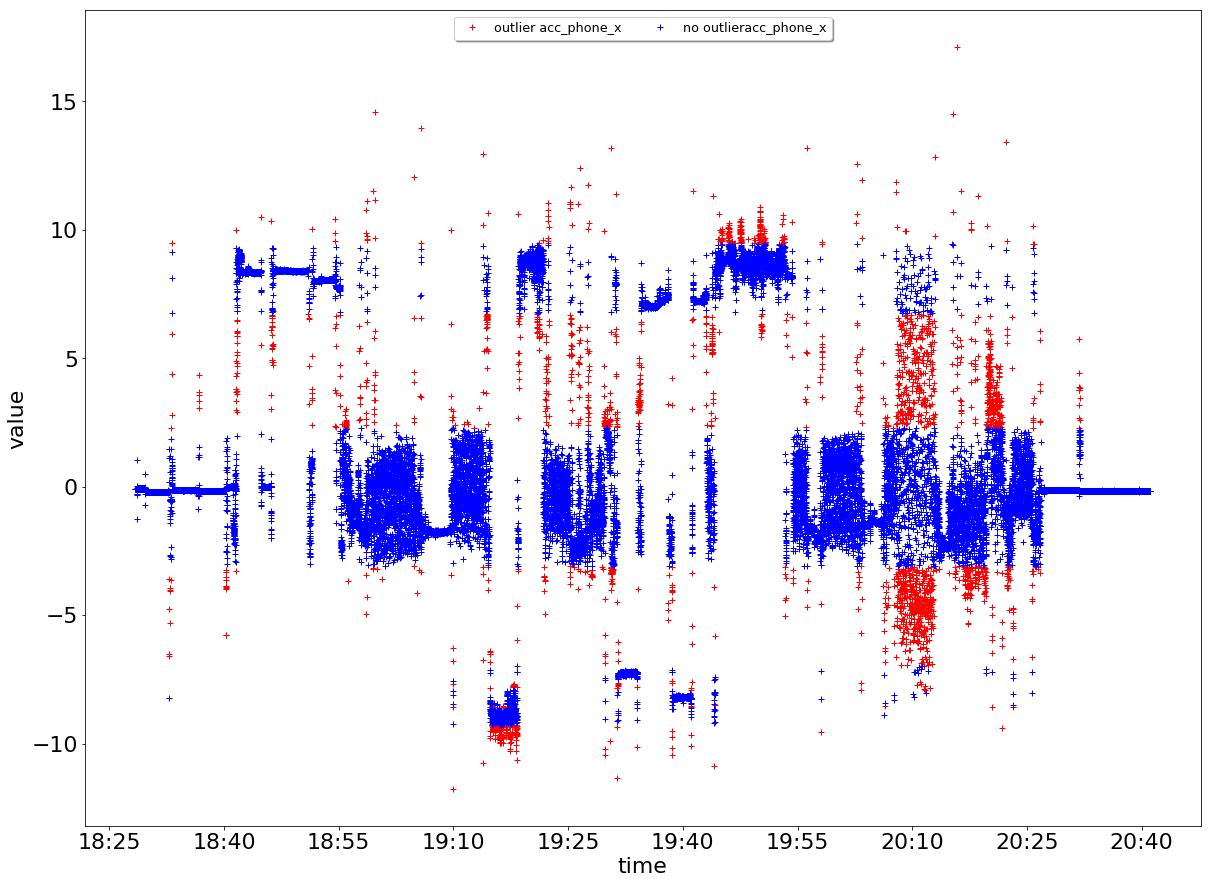

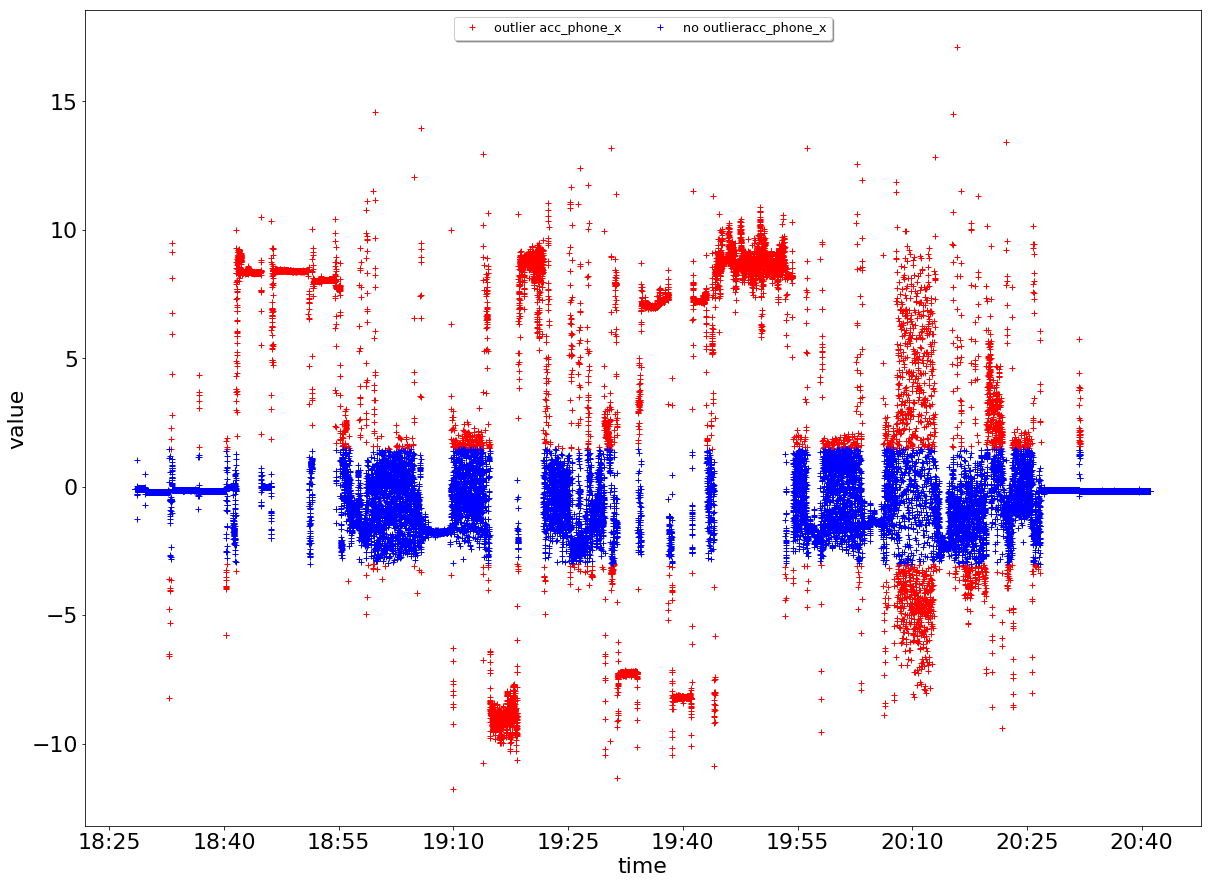

In [10]:
for params in [[.5,.99],[.01,.99],[.1,.5]]:
    dmin = params[0]
    fmin = params[1]
    dataset_outliers_sdb = OutlierDist.simple_distance_based(copy.deepcopy(data), [col], 'euclidean', dmin, fmin)
    DataViz.plot_binary_outliers(dataset_outliers_sdb, col, 'simple_dist_outlier')

### Distance-based: Local outlier factor

ML4QS-master/util/VisualizeDataset.py:36: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plot.hold(True)
/Users/davidstap/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Users/davidstap/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/Users/davidstap/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


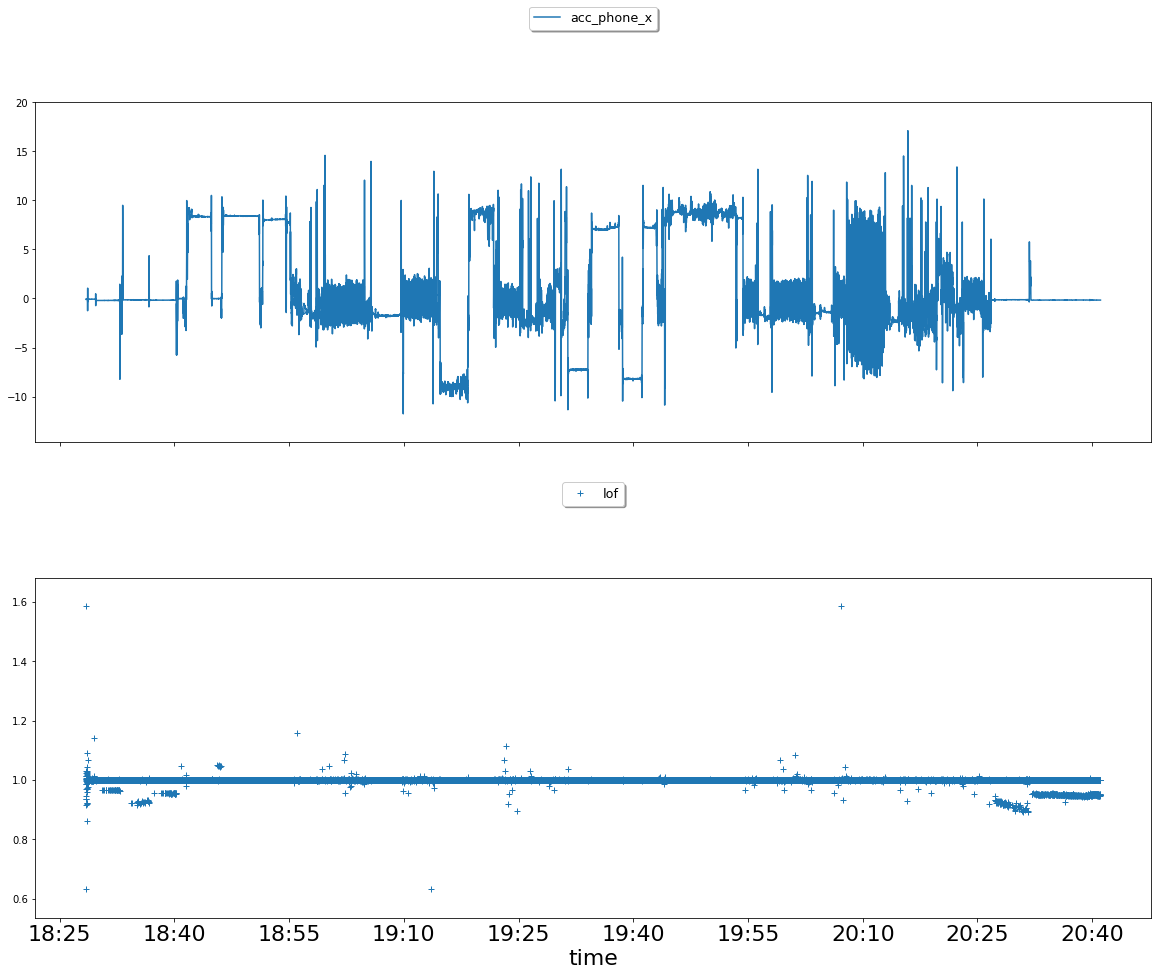

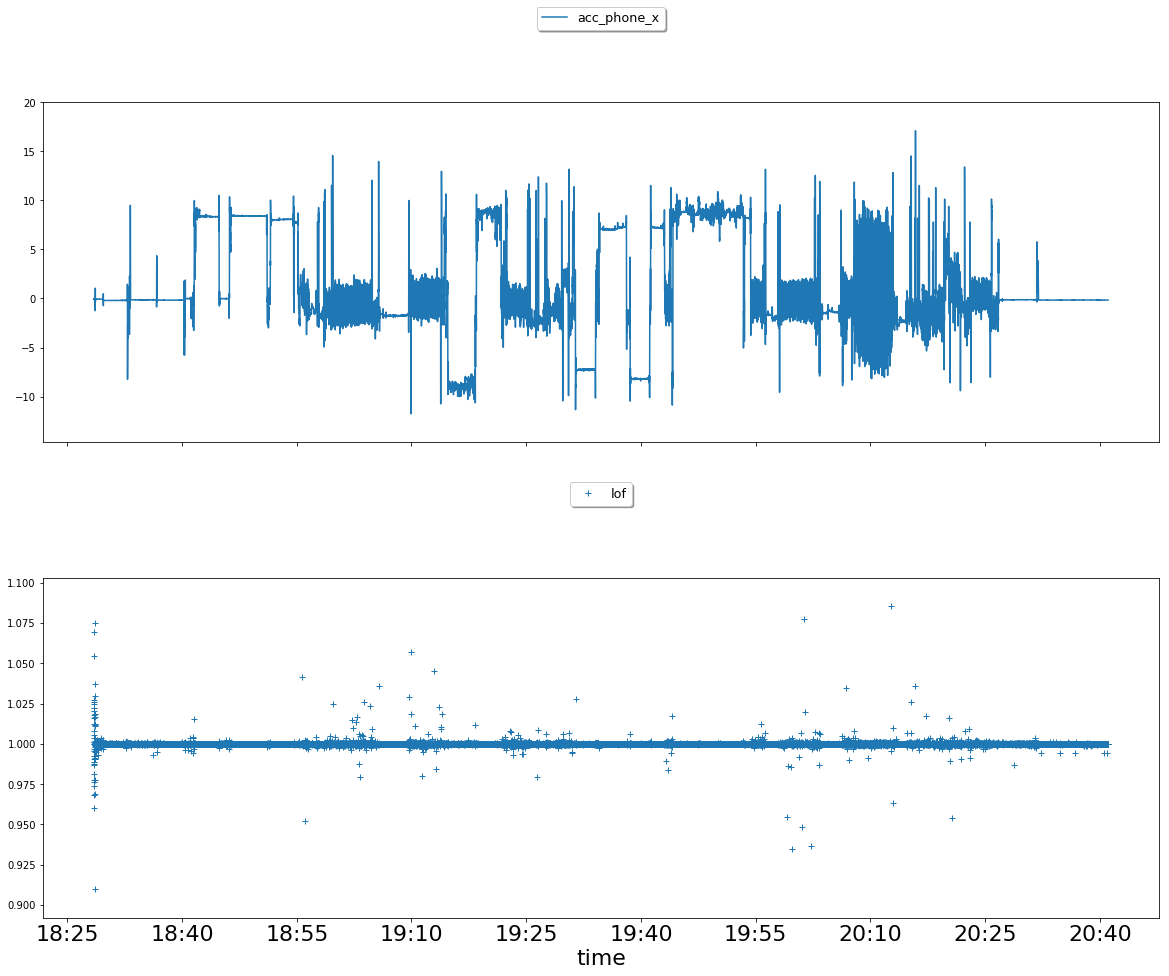

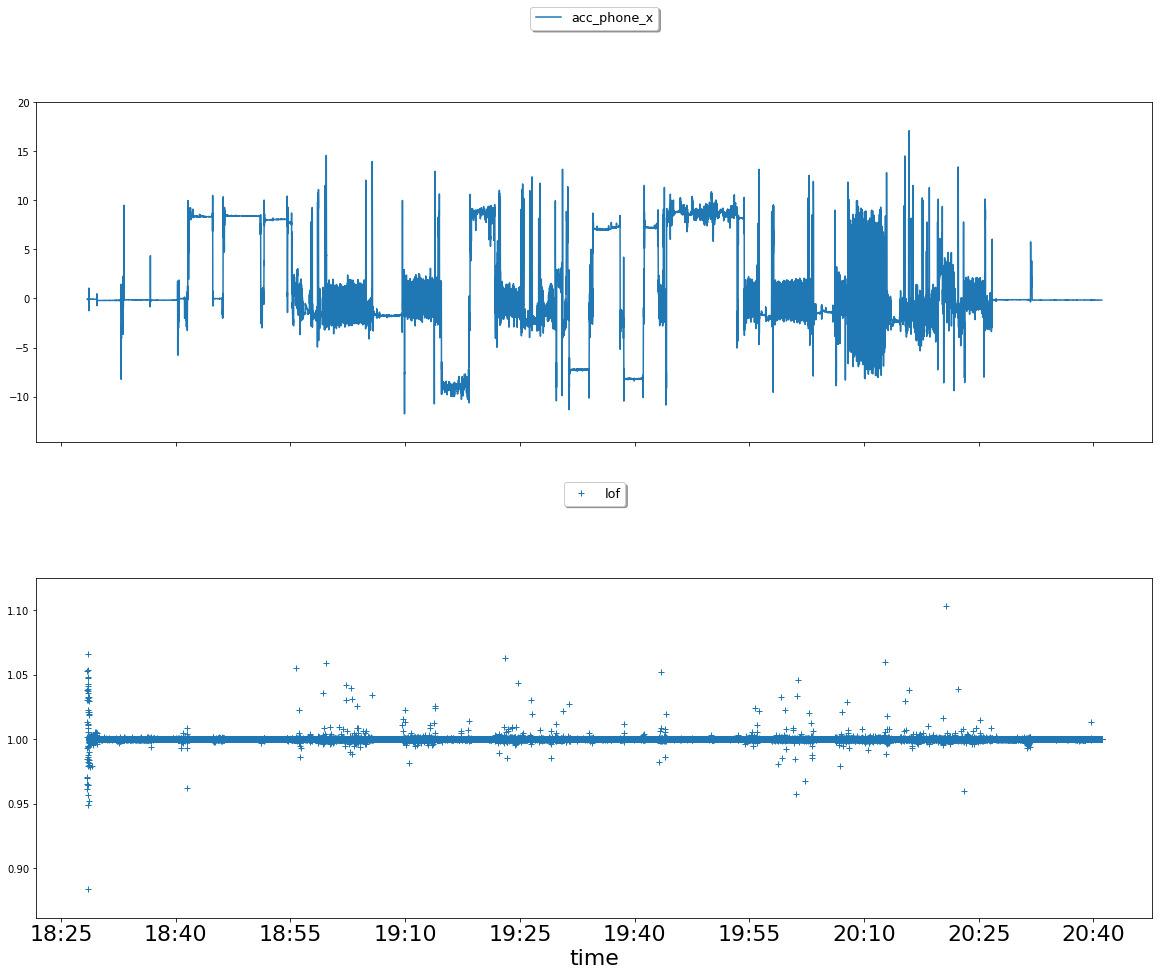

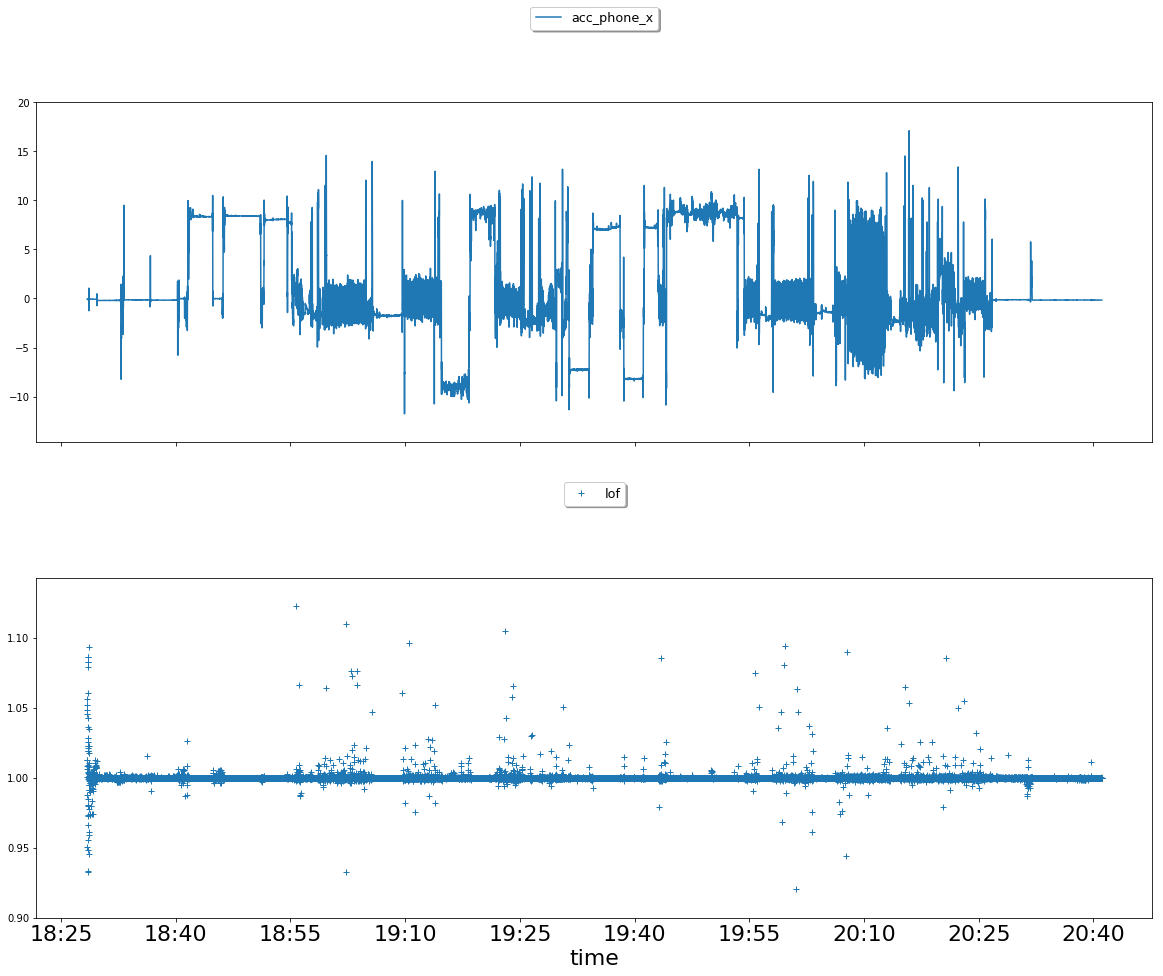

In [6]:
for k in [1,5,10,20]:
    dataset_outliers_lof = OutlierDist.local_outlier_factor(copy.deepcopy(data), [col], 'euclidean', k)
    DataViz.plot_dataset(dataset_outliers_lof, [col, 'lof'], ['exact','exact'], ['line', 'points'])

# Chapter 4: Feature Engineering Based on Sensory Data

## Practical assignment Q4.5.2.1
Explore the frequency domain features for the crowdsignals dataset in more detail, consider the individual frequencies for the different measurements and see whether you can find interesting patterns. Do you see consistent amplitudes of certain frequencies during the same activities? And how do the amplitudes differ for the different activities?

In [2]:
# Load data (use ch3 csv data)
data = pd.read_csv('./ML4QS-master/intermediate_datafiles/chapter3_result_final.csv', index_col=0)
data.index = data.index.to_datetime()

### Frequency feature: dominant frequency (i.e. max amplitude)

In [15]:
#TODO: describe results
#TODO: maybe use other features than acc_phone_x?


# Try to compare running and walking (since sitting vs walking or ontable vs walking is not so interesting --> 
# too obvious)
# Visualized / measured data for 1208 timesteps (since len data_abstract_f[data_abstract_f['labelRunning'] != 0] = 1208)
# added statistics for further insight

In [16]:
from Chapter4.FrequencyAbstraction import FourierTransformation

col = 'acc_phone_x'
milliseconds_per_instance = (data.index[1]-data.index[0]).microseconds/1000
fs = float(1000)/milliseconds_per_instance


FreqAbs = FourierTransformation()

# Do Fast Fourier Transform 
# Calculate new features: max_freq, freq_weighted, power spectral entropy
data_abstract_f = FreqAbs.abstract_frequency(copy.deepcopy(data), [col], int(float(10000)/milliseconds_per_instance), fs)

In [107]:
def get_statistics(data, cols):
    for col in cols:
        if col != 'label':
            print '\n\n'
            print 'Feature: ',col
            print 'mean: ', data[col].mean()
            print 'std: ', data[col].std()
            print 'max: ', data[col].max()
            print 'min: ',data[col].min()
            

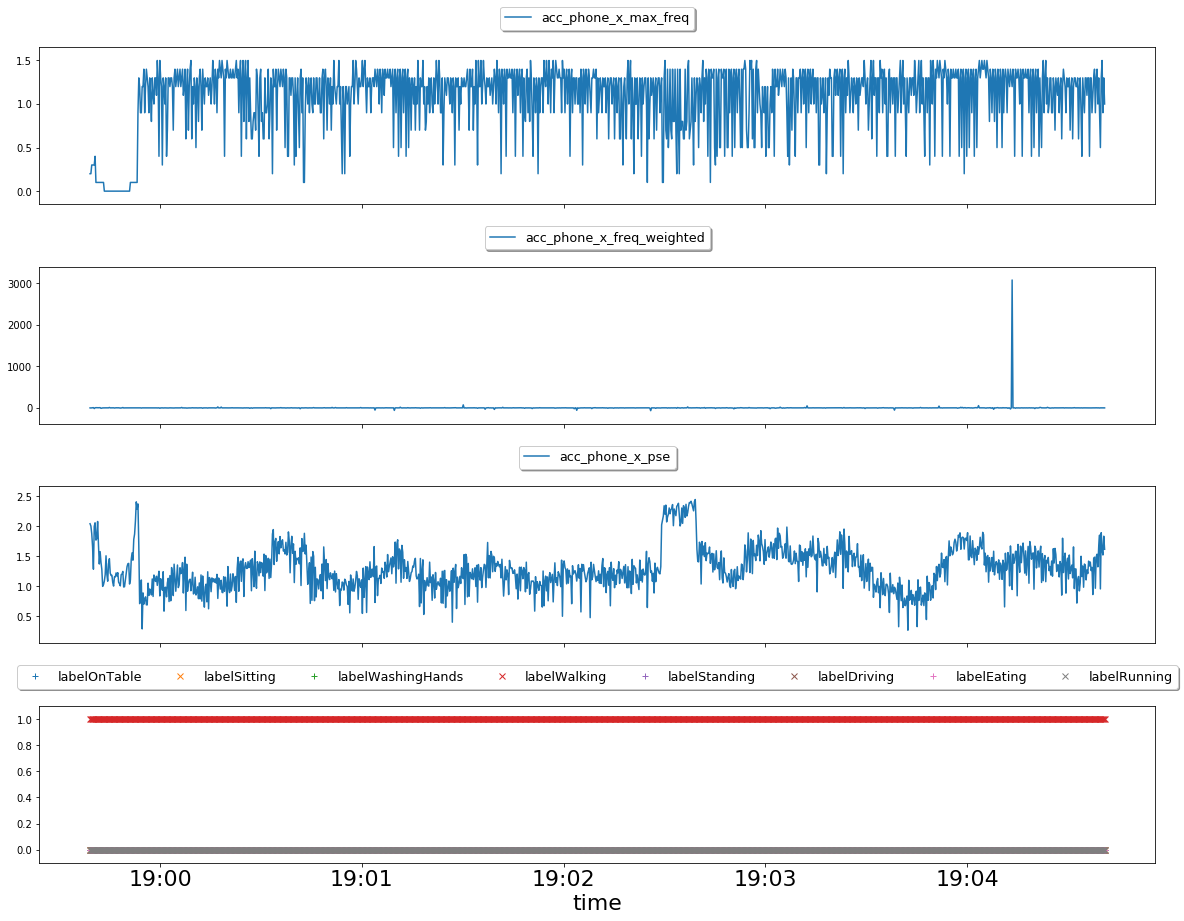




Feature:  acc_phone_x_max_freq
mean:  1.07193708609
std:  0.384322715491
max:  1.5
min:  0.0



Feature:  acc_phone_x_freq_weighted
mean:  2.29265258658
std:  88.7000509579
max:  3075.19715499
min:  -67.0313954861



Feature:  acc_phone_x_pse
mean:  1.29303024834
std:  0.351292178246
max:  2.4466235882
min:  0.26428442996


In [108]:
# Activity = Walking

# Columns we are interested in
cols = ['acc_phone_x_max_freq', 'acc_phone_x_freq_weighted', 'acc_phone_x_pse', 'label']

# walking data (same length as running for easier comparison)
walking = data_abstract_f[data_abstract_f['labelWalking'] != 0][:len(data_abstract_f[data_abstract_f['labelRunning'] != 0])]

# Visualize data
DataViz.plot_dataset(walking, cols, ['like', 'like', 'like', 'like'], ['line', 'line', 'line','points'])

# Get statistics of relevant columns
get_statistics(walking,cols)

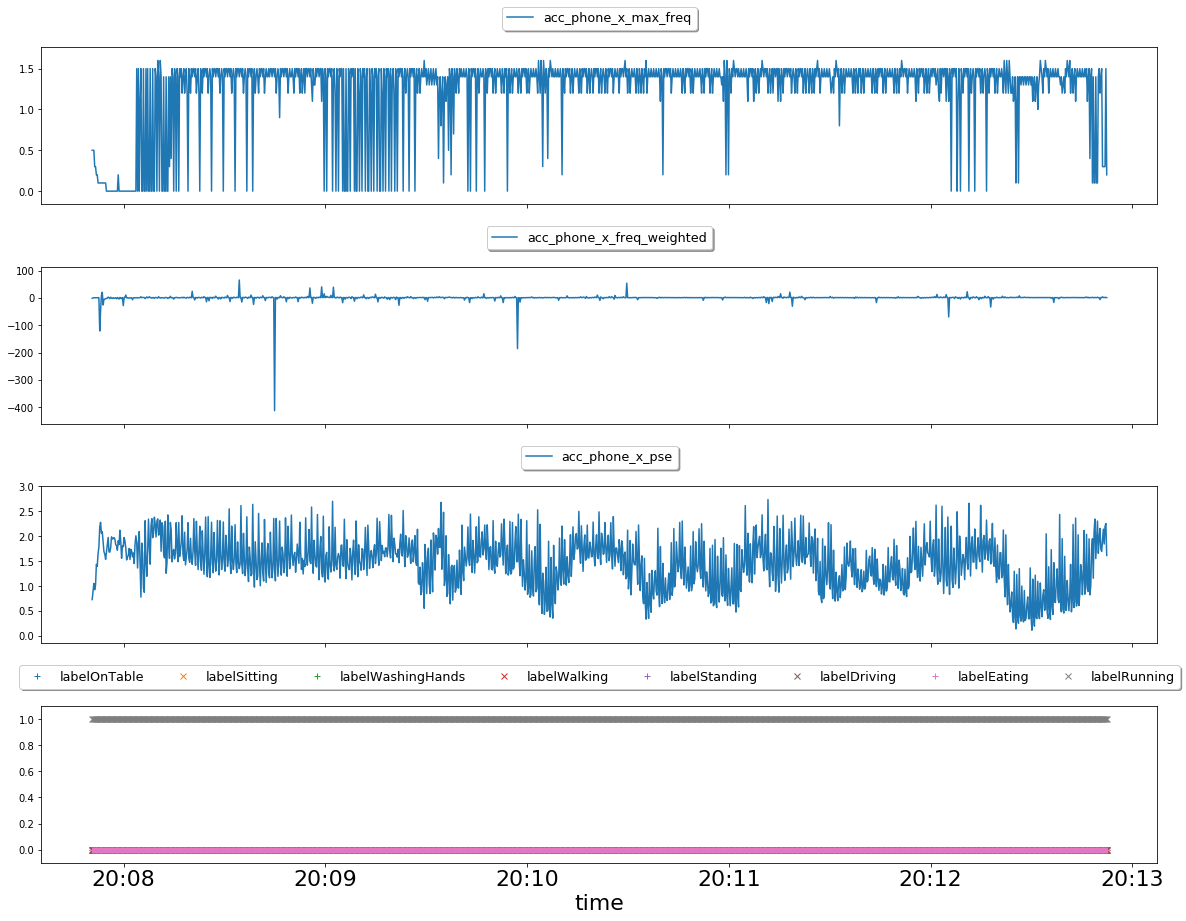




Feature:  acc_phone_x_max_freq
mean:  1.23683774834
std:  0.46246943534
max:  1.6
min:  0.0



Feature:  acc_phone_x_freq_weighted
mean:  0.206232914779
std:  14.5500269253
max:  65.4309360504
min:  -412.380530088



Feature:  acc_phone_x_pse
mean:  1.48279271267
std:  0.504705748608
max:  2.73791251755
min:  0.114859529377


In [110]:
# Activity = Running
running = data_abstract_f[data_abstract_f['labelRunning'] != 0]

DataViz.plot_dataset(running, ['acc_phone_x_max_freq', 'acc_phone_x_freq_weighted', 'acc_phone_x_pse', 'label'], ['like', 'like', 'like', 'like'], ['line', 'line', 'line','points'])

# Get statistics of relevant columns
get_statistics(running,cols)

## Practical assignment Q4.5.2.2
Implement at least two additional metrics in the time domain and the frequency domain in addition to the ones already present in the data (e.g. the ones you have identified in a previous question). Calculate them for the crowdsignals data and discuss their usefulness.

### Frequency domain additional metric: energy of frequency interval

In [3]:
# _skewness added
from Chapter4.FrequencyAbstraction import FourierTransformation

col = 'acc_phone_x'
milliseconds_per_instance = (data.index[1]-data.index[0]).microseconds/1000
fs = float(1000)/milliseconds_per_instance

FreqAbs = FourierTransformation()

data_abstract_f = FreqAbs.abstract_frequency(copy.deepcopy(data), [col], int(float(10000)/milliseconds_per_instance), fs)

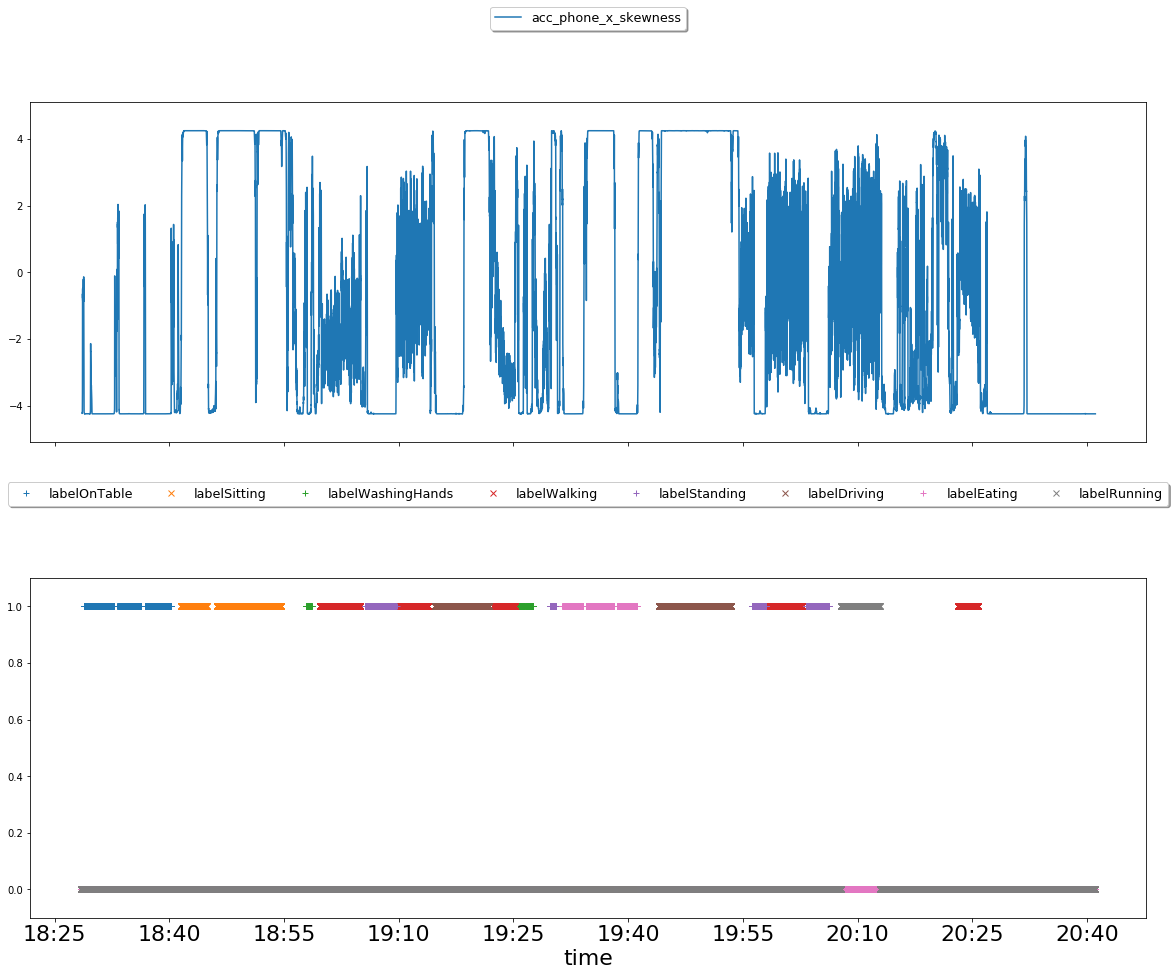

In [16]:
DataViz.plot_dataset(data_abstract_f, ['acc_phone_x_skewness', 'label'], ['like', 'like'], ['line', 'points'])

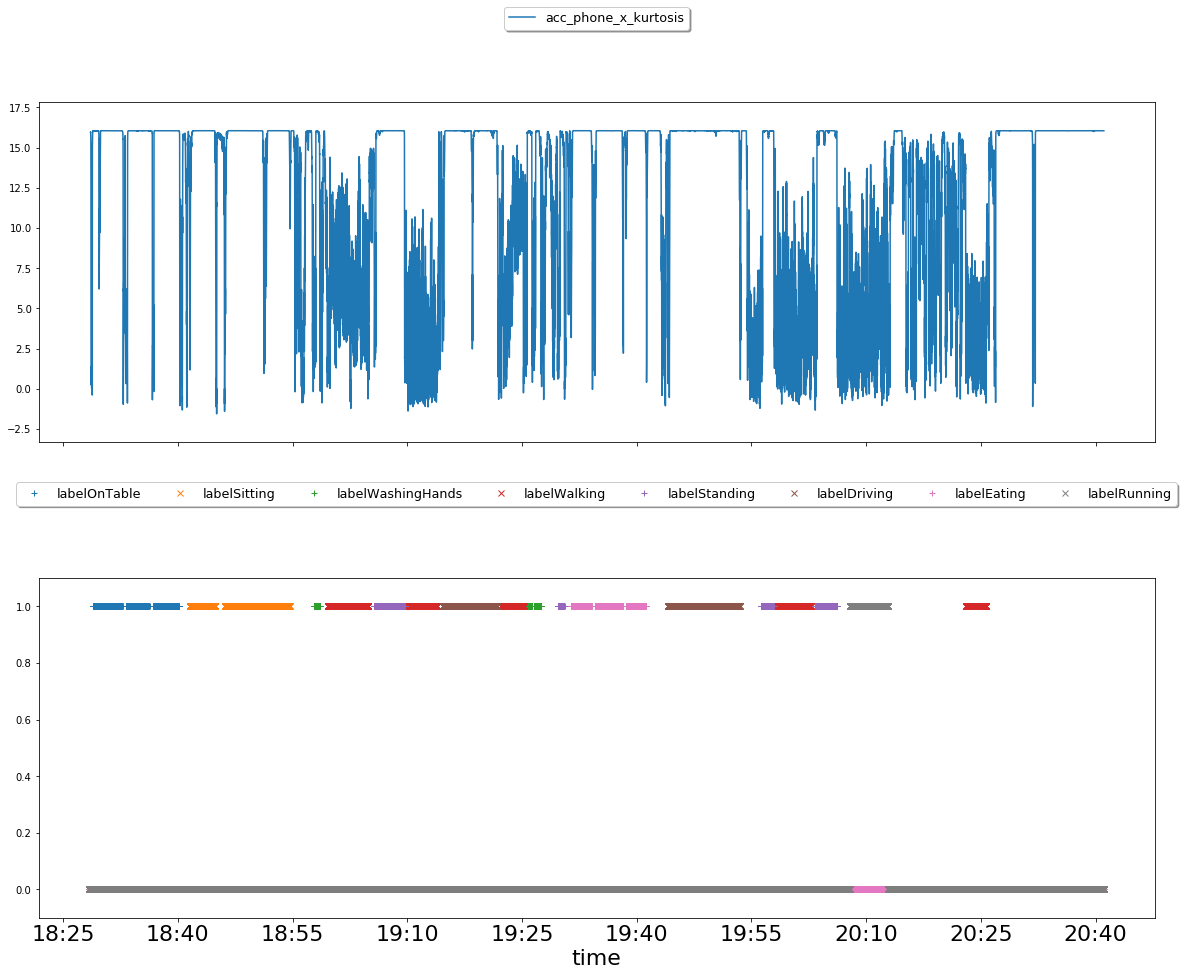

In [22]:
DataViz.plot_dataset(data_abstract_f, ['acc_phone_x_kurtosis', 'label'], ['like', 'like'], ['line', 'points'])

### Frequency domain additional metric: frequency skewedness